In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint
from Functions import *
from tqdm import tqdm

# Import and prepare data

In [2]:
infected = pd.read_csv('China_save/China_infected.csv')
removed = pd.read_csv('China_save/China_removed.csv')

In [3]:
it=infected['0'].to_numpy()
rt=removed['0'].to_numpy()

In [6]:
split=[0,120,168,262,350,415]

i1=it[split[0]:split[2]]
r1=rt[split[0]:split[2]]
i2=it[split[2]:split[3]]
r2=rt[split[2]:split[3]]
# i3=it[split[2]:split[3]]
# r3=it[split[2]:split[3]]
i3=it[split[4]:]
r3=rt[split[4]:]

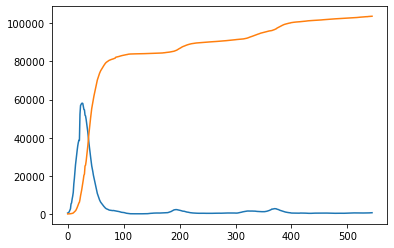

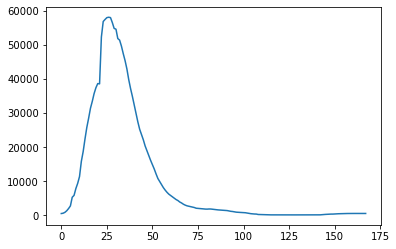

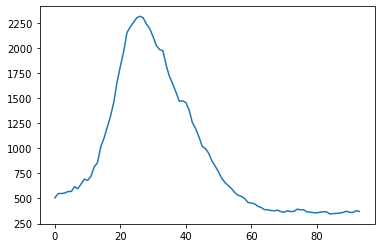

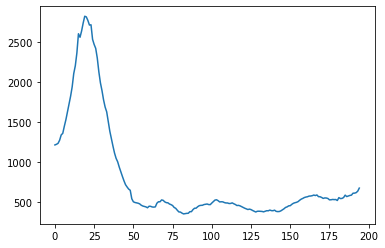

In [7]:
plt.plot(range(len(it)),it)
plt.plot(range(len(rt)),rt)
plt.show()
plt.plot(range(len(i1)),i1)
plt.show()
plt.plot(range(len(i2)),i2)
plt.show()
plt.plot(range(len(i3)),i3)
plt.show()
# plt.plot(range(len(i4)),i4)
# plt.show()

In [8]:
N=140000
inf1=i1/N
rem1=r1/N
inf2=i2/N
rem2=r2/N
inf3=i3/N
rem3=r3/N
# inf4=i4/N
# rem4=r4/N

In [9]:
ratio=rem1[0]/inf1[0]
rem2[0]=inf2[0]*ratio
rem3[0]=inf3[0]*ratio

# Rescale policies

For different policies, the scales are different. See https://ourworldindata.org/policy-responses-covid

In [10]:
policy = pd.read_csv('China_save/China_policy_use.csv')

In [11]:
policy.columns

Index(['Day', 'testing_policy', 'contact_tracing', 'vaccination_policy',
       'debt_relief', 'facial_coverings', 'income_support',
       'restrictions_internal_movements', 'international_travel_controls',
       'public_information_campaigns', 'cancel_public_events',
       'restriction_gatherings', 'close_public_transport', 'school_closures',
       'stay_home_requirements', 'workplace_closures'],
      dtype='object')

In [12]:
po1=policy.copy()

In [13]:
po1['testing_policy']=policy['testing_policy']/3
po1['contact_tracing']=policy['contact_tracing']/2
po1['vaccination_policy']=policy['vaccination_policy']/5
po1['debt_relief']=policy['debt_relief']/2
po1['facial_coverings']=policy['facial_coverings']/4
po1['income_support']=policy['income_support']/2
po1['restrictions_internal_movements']=policy['restrictions_internal_movements']/2
po1['international_travel_controls']=policy['international_travel_controls']/4
po1['public_information_campaigns']=policy['public_information_campaigns']/2
po1['cancel_public_events']=policy['cancel_public_events']/2
po1['restriction_gatherings']=policy['restriction_gatherings']/4
po1['close_public_transport']=policy['close_public_transport']/2
po1['school_closures']=policy['school_closures']/3
po1['stay_home_requirements']=policy['stay_home_requirements']/3
po1['workplace_closures']=policy['workplace_closures']/3

In [14]:
po2=po1.drop(['Day'],axis=1)

In [15]:
p1=po2[split[0]:split[1]]
p2=po2[split[2]:split[3]]
p3=po2[split[4]:split[5]]

# Fit SIR models, and abtain all data points for neural network training

In [16]:
# With in a peak, train from 30 days or s0, and get a data point for every day.
def one_peak(inf,rem,po,start=20):
    duration = inf.shape[0]
    results=[]
    x_train=[]
    index=[]
    for i in tqdm(range(start, duration)):
        result=run(inf[:i],rem[:i])
        reletive_error=[]
        for name, param in result[2].params.items():
            reletive_error.append(param.stderr/param.value)
        if np.all(np.array(reletive_error[3:]) < 0.05):
            results.append(result)
            x_train.append(po[:60].mean().to_numpy())
#             x_train.append(po[i-1:i].to_numpy()[0])
            index.append(i)
    return results, x_train, index

In [17]:
results, x_train, index=one_peak(inf1,rem1,p1,start=20)
results2, x_train2, index2=one_peak(inf2,rem2,p2,start=20)
results3, x_train3, index3=one_peak(inf3,rem3,p3,start=20)
# results4, x_train4, index4=one_peak(inf4,rem4,p4,start=20)

100%|████████████████████████████████████████████████████████████████████████████████| 175/175 [00:04<00:00, 36.37it/s]


In [18]:
len(x_train),len(x_train2),len(x_train3)
# ,len(x_train4)

(141, 56, 165)

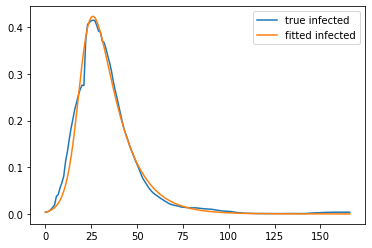

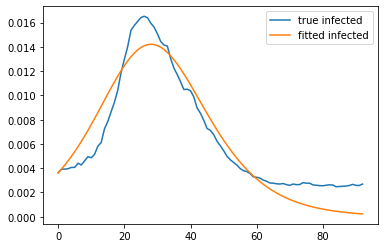

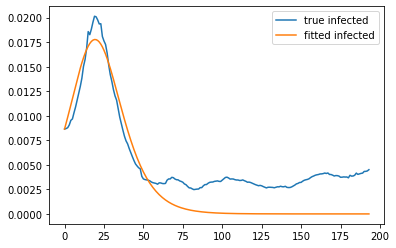

In [19]:
plot_fit(results[-1],inf1[:index[-1]])
plot_fit(results2[-1],inf2[:index2[-1]])
plot_fit(results3[-1],inf3[:index3[-1]])

# Prepare data for neural network

In [20]:
df_x1=pd.DataFrame(x_train)
df_x2=pd.DataFrame(x_train2)
df_x3=pd.DataFrame(x_train3)
# df_x4=pd.DataFrame(x_train4)

In [21]:
df_x=df_x1.append(df_x2)
df_x=df_x.append(df_x3)
# df_x=df_x.append(df_x4)

In [22]:
df_x.to_csv('China_save/x_train.csv')

In [23]:
def get_pa(results):
    beta=[]
    gamma=[]
    for result in results:
        beta.append(result[2].params['beta'].value)
        gamma.append(result[2].params['gamma'].value)
    return beta, gamma

In [24]:
beta1, gamma1 = get_pa(results)
beta2, gamma2 = get_pa(results2)
beta3, gamma3 = get_pa(results3)
# beta4, gamma4 = get_pa(results4)
df_y1=pd.DataFrame({'beta':beta1,'gamma':gamma1})
df_y2=pd.DataFrame({'beta':beta2,'gamma':gamma2})
df_y3=pd.DataFrame({'beta':beta3,'gamma':gamma3})
# df_y4=pd.DataFrame({'beta':beta4,'gamma':gamma4})
df_y=df_y1.append(df_y2)
df_y=df_y.append(df_y3)
# df_y=df_y.append(df_y4)

In [25]:
df_y.to_csv('China_save/y_train.csv')

In [26]:
index=np.array(index)
index2=np.array(index2)
index3=np.array(index3)
# index4=np.array(index4)

In [27]:
np.save('China_save/fit_index1.npy',index)
np.save('China_save/fit_index2.npy',index2)
np.save('China_save/fit_index3.npy',index3)
# np.save('China_save/fit_index4.npy',index4)

In [30]:
df_y3

,beta,gamma
0,0.469590,0.401474
1,0.481892,0.412231
2,0.492029,0.421028
3,0.499815,0.427738
4,0.505393,0.432507
...,...,...
160,0.516080,0.443398
161,0.516099,0.443414
162,0.516123,0.443434
163,0.516138,0.443447
